In [1]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import numpy as np


In [3]:
# Load GoEmotions dataset
dataset = load_dataset("google-research-datasets/go_emotions")

# Check the structure of the dataset
print(dataset)

# Access the training, validation, and test splits
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']


# Access the training, validation, and test splits
train_data = dataset['train'].select(range(100))
val_data = dataset['validation'].select(range(100))
test_data = dataset['test'].select(range(100))

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [4]:
# Check basic information about the train dataset
print(f"Training set: {len(train_data)} rows")
print(f"Validation set: {len(val_data)} rows")
print(f"Test set: {len(test_data)} rows")

# Explore the feature names of the dataset
print(f"Features: {train_data.features}")

# Check for missing values
def check_missing(data):
    missing_count = 0
    for row in data:
        if None in row.values():
            missing_count += 1
    return missing_count

print(f"Missing values in train: {check_missing(train_data)}")
print(f"Missing values in validation: {check_missing(val_data)}")
print(f"Missing values in test: {check_missing(test_data)}")


Training set: 100 rows
Validation set: 100 rows
Test set: 100 rows
Features: {'text': Value(dtype='string', id=None), 'labels': Sequence(feature=ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], id=None), length=-1, id=None), 'id': Value(dtype='string', id=None)}
Missing values in train: 0
Missing values in validation: 0
Missing values in test: 0


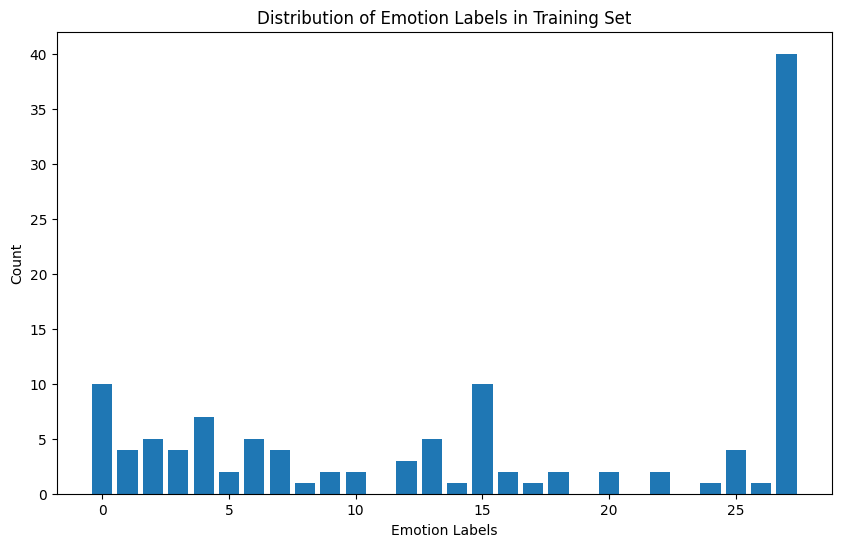

Label distribution in the training set: Counter({27: 40, 15: 10, 0: 10, 4: 7, 2: 5, 6: 5, 13: 5, 3: 4, 1: 4, 25: 4, 7: 4, 12: 3, 20: 2, 5: 2, 22: 2, 9: 2, 16: 2, 18: 2, 10: 2, 14: 1, 26: 1, 8: 1, 17: 1, 24: 1})


In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to flatten the label lists for analysis
def get_label_distribution(data):
    all_labels = [label for row in data for label in row['labels']]
    return Counter(all_labels)

# Get label distribution for train, validation, and test sets
train_labels = get_label_distribution(train_data)
val_labels = get_label_distribution(val_data)
test_labels = get_label_distribution(test_data)

# Plot label distribution for the training set
plt.figure(figsize=(10, 6))
plt.bar(train_labels.keys(), train_labels.values())
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels in Training Set')
plt.show()

print(f"Label distribution in the training set: {train_labels}")


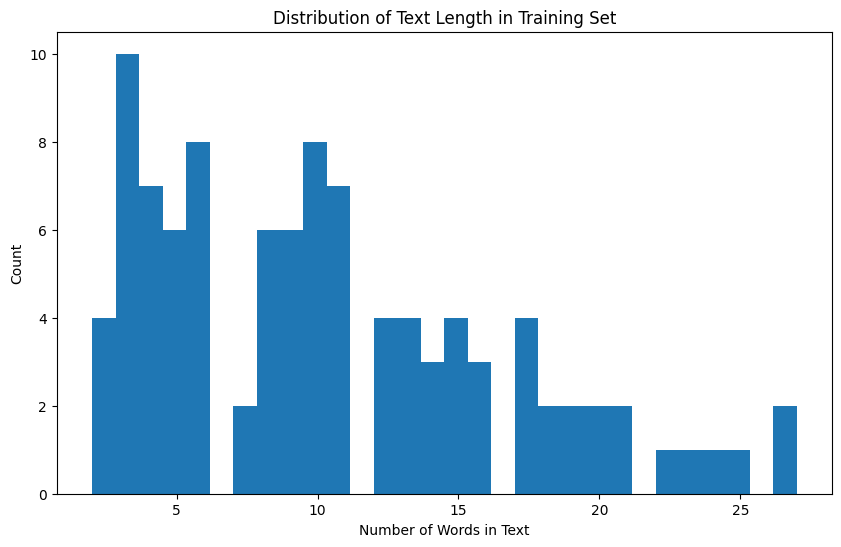

Average text length in the training set: 10.39


In [6]:
# Check the distribution of text lengths in the train dataset
train_text_lengths = [len(row['text'].split()) for row in train_data]

plt.figure(figsize=(10, 6))
plt.hist(train_text_lengths, bins=30)
plt.xlabel('Number of Words in Text')
plt.ylabel('Count')
plt.title('Distribution of Text Length in Training Set')
plt.show()

print(f"Average text length in the training set: {sum(train_text_lengths) / len(train_text_lengths)}")


In [7]:
from transformers import AutoTokenizer

# Load the pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

import numpy as np

# Number of unique labels in the dataset (from 0 to 27 for GoEmotions dataset)
NUM_LABELS = 28

# Function to tokenize data and format labels for multi-label classification
from datasets import ClassLabel

# Ensure labels are handled as multi-label
def tokenize_data(examples):
    tokenized = tokenizer(examples['text'], padding=True, truncation=True, max_length=512)
    # Assuming labels are lists of integers
    tokenized['labels'] = [[1 if i in label else 0 for i in range(28)] for label in examples['labels']]
    return tokenized


# Apply tokenization to the dataset
train_data = train_data.map(tokenize_data, batched=True)
val_data = val_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)




c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get all labels
all_labels = [label for labels in train_data['labels'] for label in labels]

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: 0.5223880597014925, 1: 11.666666666666666}


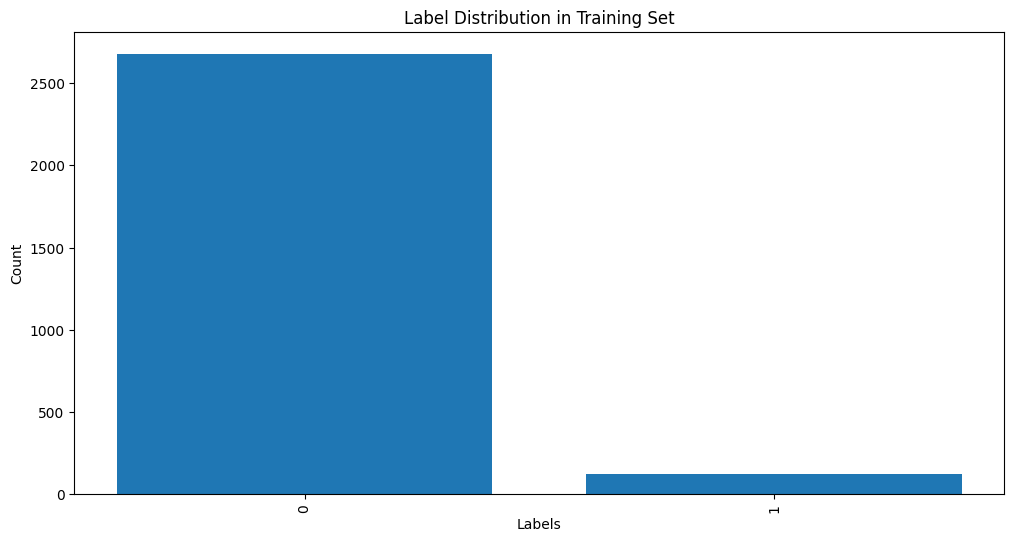

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Label distribution in the training set
label_counts = Counter([label for labels in train_data['labels'] for label in labels])

# Plotting the label distribution
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(list(label_counts.keys()), rotation=90)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution in Training Set")
plt.show()


Preprocessing of the dataset

In [10]:
from transformers import BertForSequenceClassification
import torch
from torch import nn

# Custom model class for multi-label classification using BCEWithLogitsLoss
class BertForMultiLabelSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Get the model outputs
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)

        # Return the logits directly if no labels are provided
        loss = None
        if labels is not None:
            labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)

        return (loss, logits) if loss is not None else logits

# Load the model with custom loss function
model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-uncased", num_labels=28)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [11]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Load BERT pre-trained model for multi-label classification
# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased',
#     num_labels=len(train_data.features['labels'].feature.names),
#     problem_type="multi_label_classification"
# )

# Function to compute metrics like accuracy, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)  # Apply threshold to convert logits to binary predictions
    f1 = f1_score(labels, predictions, average='macro')  # or use 'micro' based on your need
    return {'f1_score': f1}



In [12]:
# training_args = TrainingArguments(
#     output_dir="/content/results",          # Output directory
#     evaluation_strategy="epoch",            # Evaluate at the end of each epoch
#     save_strategy="epoch",                  # Save the model at each epoch
#     per_device_train_batch_size=16,         # Batch size for training
#     per_device_eval_batch_size=16,          # Batch size for evaluation
#     num_train_epochs=3,                     # Number of epochs
#     logging_dir="/content/logs",            # Directory for storing logs
#     logging_steps=10,                       # Log every 10 steps
#     load_best_model_at_end=True,            # Load the best model when finished training
# )

training_args = TrainingArguments(
    output_dir="/content/results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,  # Increase batch size
    per_device_eval_batch_size=8,   # Increase eval batch size
    num_train_epochs=3,
    logging_dir="/content/logs",
    logging_steps=5,
    save_steps=500,  # Save every 500 steps to avoid frequent saving
    load_best_model_at_end=True,
    fp16=True
)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
from transformers import DataCollatorWithPadding

# Define the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define the Trainer and model training arguments
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    optimizers=(optimizer, None),  # None for lr_scheduler
    compute_metrics=compute_metrics
)




c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Train the model
trainer.train()

  0%|          | 0/39 [00:00<?, ?it/s]

{'loss': 0.6561, 'grad_norm': 1.351069688796997, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.38}
{'loss': 0.5802, 'grad_norm': 1.4999350309371948, 'learning_rate': 3.717948717948718e-05, 'epoch': 0.77}


  0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.4907453954219818, 'eval_f1_score': 0.007202881152460984, 'eval_runtime': 3.9786, 'eval_samples_per_second': 25.135, 'eval_steps_per_second': 3.268, 'epoch': 1.0}
{'loss': 0.5091, 'grad_norm': 1.3162751197814941, 'learning_rate': 3.0769230769230774e-05, 'epoch': 1.15}
{'loss': 0.4514, 'grad_norm': 1.1886149644851685, 'learning_rate': 2.435897435897436e-05, 'epoch': 1.54}
{'loss': 0.4076, 'grad_norm': 1.0436453819274902, 'learning_rate': 1.794871794871795e-05, 'epoch': 1.92}


  0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.38072654604911804, 'eval_f1_score': 0.0, 'eval_runtime': 4.3414, 'eval_samples_per_second': 23.034, 'eval_steps_per_second': 2.994, 'epoch': 2.0}
{'loss': 0.3769, 'grad_norm': 1.0446516275405884, 'learning_rate': 1.153846153846154e-05, 'epoch': 2.31}
{'loss': 0.3608, 'grad_norm': 0.8641543984413147, 'learning_rate': 5.128205128205128e-06, 'epoch': 2.69}


  0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.34962600469589233, 'eval_f1_score': 0.0, 'eval_runtime': 4.0241, 'eval_samples_per_second': 24.85, 'eval_steps_per_second': 3.231, 'epoch': 3.0}
{'train_runtime': 78.6638, 'train_samples_per_second': 3.814, 'train_steps_per_second': 0.496, 'train_loss': 0.46509777582608736, 'epoch': 3.0}


TrainOutput(global_step=39, training_loss=0.46509777582608736, metrics={'train_runtime': 78.6638, 'train_samples_per_second': 3.814, 'train_steps_per_second': 0.496, 'total_flos': 6476510174400.0, 'train_loss': 0.46509777582608736, 'epoch': 3.0})

In [15]:
# Evaluate the model on validation data
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

  0%|          | 0/13 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.34962600469589233, 'eval_f1_score': 0.0, 'eval_runtime': 4.1719, 'eval_samples_per_second': 23.97, 'eval_steps_per_second': 3.116, 'epoch': 3.0}


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
def predict(text, threshold=0.5):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]  # Change as necessary based on your model output
    probs = torch.sigmoid(logits)

    # Adjusting threshold for predictions
    predictions = (probs > threshold).int()

    return predictions


In [17]:
# Test example
example_text = "I love this movie!"
preds = predict(example_text)
print("Predicted labels:", preds)


Predicted labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.int32)


In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Assuming 'model' is your trained model and 'tokenizer' is your tokenizer
model_save_path = r'C:\temp\trained_model'

# Save the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


Model and tokenizer saved to C:\temp\trained_model


In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved path
model_load_path = r'C:\temp\trained_model'
tokenizer = AutoTokenizer.from_pretrained(model_load_path)
model = AutoModelForSequenceClassification.from_pretrained(model_load_path)

# Example inference for a single test instance
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits)
    predictions = (probs > 0.5).int()
    return predictions
